In [1]:
!pip3.12 install numpy


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from Mass_calculator import Mass
import Cit_par24 as params
from sklearn.linear_model import LinearRegression

Data dictionary path = c:\Users\moheb\Desktop\Y3\SVV Flight\B46\Data_dict_SIunits.pkl


In [3]:

class StickForce:
    def __init__(self, data_file: str, time_interval: tuple):
        '''
        :param data_file: name of the data file to read into dict
        :param time_interval: start and end times
        '''
        with open(data_file, 'rb') as pickle_file:
            Data_Dict_loaded = pickle.load(pickle_file)
        print(Data_Dict_loaded.keys())

        self.T_0 = params.Temp0 #[K]
        self.lam = params.lamb # [K m^-1]
        self.p_0 = params.p0 # [Pa]
        self.g_0 = params.g # [m s^-2]
        self.R = params.R #[J kg^-1 K^-1]
        self.rho_0 = params.rho0 #[kg m^-3]
        self.W_s = 60500 #[n]
        self.gamma = 1.4 #[]
        self.mfs = 0.048 # [kg s^-1]
        self.CmTc = params.CmTc

        self.t_start, self.t_end = time_interval
        self.mass = Mass().NewMass_calculator()                        # [kg]

        self.time = Data_Dict_loaded['time']                           # [s]
        self.Mach_meas = Data_Dict_loaded['Dadc1_mach']                # [-]
        self.V_c = Data_Dict_loaded['Dadc1_cas']# * 0.514444444         # [m s^-1]
        self.V_t = Data_Dict_loaded['Dadc1_tas']# * 0.514444444         # [m s^-1]
        self.T_m = Data_Dict_loaded['Dadc1_tat']#+274.15                # [K]
        self.h_p = Data_Dict_loaded['Dadc1_alt']#*.3048                 # [m]
        self.T_stat = Data_Dict_loaded['Dadc1_sat']#+274.15             # [K]
        self.delta_e = Data_Dict_loaded['delta_e']#*np.pi/180           # [rad]
        self.AOA = Data_Dict_loaded['vane_AOA']#*np.pi/180              # [rad]
        self.lff = Data_Dict_loaded['lh_engine_FMF']#*.453592/3600      # [kg s^-1]
        self.rff = Data_Dict_loaded['rh_engine_FMF']#*.453592/3600      # [kg s^-1]

    @staticmethod
    def sort_array(array_to_sort, value_array):
        idx_sort = value_array.argsort()
        return array_to_sort[idx_sort[::-1]]

    @staticmethod
    def calc_grad(x, y):
        ' Calculate gradient of linear regression (x,y)'
        model = LinearRegression().fit(x, y)
        return model.coef_

    def calc_rho(self, p: np.array, T: np.array):
        '''
        :param p: static pressure
        :param T: static temperature
        :return: density from ideal gas law
        '''
        rho = p / (self.R * T)
        return rho

    def calc_pressure(self, h_p: np.array):
        '''
        :param h_p: pressure altitude
        :return: static pressure
        '''
        p = self.p_0 * (1 + self.lam * h_p / self.T_0) ** (-self.g_0 / (self.lam * self.R))
        return p

    def calc_V_e_direct(self):
        '''
        :return: equivalent airspeed from measured TAS
        '''
        p = self.calc_pressure(h_p = self.h_p)
        rho = self.calc_rho(p=p, T = self.T_stat)
        V_e = self.V_t*np.sqrt(rho/self.rho_0)
        # print(f"Pressure => {p}")
        # print(10*"-")
        # print(f"rho is {rho}")
        # print(10*"-")
        # print(f"self.T_stat => {self.T_stat}")
        # print(10*"-")
        # print(f"Ve => {V_e}")
        # print(10*"-")
        # print(f"Ve => {self.V_t}")
        return V_e

    def reduce_V_e(self, V_e: np.array):
        '''
        :param V_e: equivalent airspeed
        :param Mass: aircraft mass
        :return:
        '''
        W = self.mass * self.g_0
        return V_e * np.sqrt(self.W_s/W)

    

    def plot_checks(self):
        'manually recorded data:'
        time_man_arr = np.array([35, 37, 39, 41, 43, 44, 46]) * 60  # [s]
        h_p_man_arr = np.array([13070, 13400, 13770, 14176, 13512, 13184, 12454]) * .3048  # [m]
        T_m_man_arr = np.array([-11.5, -12.5, -13.8, -15.2, -12, -10.5, -8.2]) + 274.15  # [K]
        V_c_man_arr = np.array([157.8, 148, 138, 132, 170.4, 179, 189.6]) * 0.514444444  # [m s^-1]
        delta_e_man_arr = np.array([0.1, -0.233333333, -0.7, -1, 0.6, 0.8, 1.1])*np.pi/180   #[rad]

        'plot checks:'
        plt.plot(self.time, self.delta_e)
        plt.plot(time_man_arr, delta_e_man_arr)
        plt.show()

        plt.plot(time_man_arr, h_p_man_arr)
        plt.plot(self.time, self.h_p)
        plt.show()

        plt.plot(time_man_arr, T_m_man_arr)
        plt.plot(self.time, self.T_m)
        plt.show()

        plt.plot(time_man_arr, V_c_man_arr)
        plt.plot(self.time, self.V_c)
        plt.show()


In [4]:
mTimes = np.array([35, 37, 39, 41, 43, 44, 46]) * 60.
Fe = np.array([-1, -13.5, -31.5, -38, 29, 47.5, 75.5])
calculator = StickForce(data_file='Data_Dict_SIunits.pkl', time_interval=(35*60, 46*60))



dict_keys(['vane_AOA', 'elevator_dte', 'column_fe', 'lh_engine_FMF', 'rh_engine_FMF', 'lh_engine_itt', 'rh_engine_itt', 'lh_engine_OP', 'rh_engine_OP', 'column_Se', 'lh_engine_fan_N1', 'lh_engine_turbine_N2', 'rh_engine_fan_N1', 'rh_engine_turbine_N2', 'lh_engine_FU', 'rh_engine_FU', 'delta_a', 'delta_e', 'delta_r', 'Gps_date', 'Gps_utcSec', 'Ahrs1_Roll', 'Ahrs1_Pitch', 'Fms1_trueHeading', 'Gps_lat', 'Gps_long', 'Ahrs1_bRollRate', 'Ahrs1_bPitchRate', 'Ahrs1_bYawRate', 'Ahrs1_bLongAcc', 'Ahrs1_bLatAcc', 'Ahrs1_bNormAcc', 'Ahrs1_aHdgAcc', 'Ahrs1_xHdgAcc', 'Ahrs1_VertAcc', 'Dadc1_sat', 'Dadc1_tat', 'Dadc1_alt', 'Dadc1_bcAlt', 'Dadc1_bcAltMb', 'Dadc1_mach', 'Dadc1_cas', 'Dadc1_tas', 'Dadc1_altRate', 'measurement_running', 'measurement_n_rdy', 'display_graph_state', 'display_active_screen', 'time'])


In [5]:
Ve = calculator.calc_V_e_direct()
reduced_ve = calculator.reduce_V_e(Ve)
weights = calculator.mass

In [21]:
Ve

array([6.89465313e-304, 6.89465313e-304, 6.89465313e-304, ...,
       1.62980433e-103, 5.43816636e-104, 2.31075750e-104])

In [7]:
with open('Data_Dict_SIunits.pkl', 'rb') as pickle_file:
    Data_Dict_loaded = pickle.load(pickle_file)

In [8]:
timestamps = [35*60, 37*60, 39*60, 41*60, 43*60, 44*60, 46*60]
list_of_indexes = []
for i in timestamps:
    one_index = np.where(i == Data_Dict_loaded['time'])
    one_index = one_index[0][0] #+ 1
    list_of_indexes.append(one_index)

In [9]:
list_of_indexes

[20910, 22110, 23310, 24510, 25710, 26310, 27510]

----

In [10]:
weights_in_timestamps = []

In [11]:
for index in list_of_indexes:
    weights_in_timestamps.append(weights[index])

In [12]:
weights_in_timestamps = [weight * 9.80665 for weight in weights_in_timestamps]

In [13]:
reduced_ve_in_timestamps = [] 

In [14]:
for index in list_of_indexes:
    reduced_ve_in_timestamps.append(reduced_ve[index]) 

-----

In [15]:
W_s = calculator.W_s

In [16]:
def Fe_aero_reduced():
    F_red = Fe*([W_s] * 7)/weights_in_timestamps
    return F_red

In [17]:
#plotting
F_red = Fe_aero_reduced()


In [18]:
F_red

array([ -1.01420473, -13.69176742, -31.94746567, -38.53980979,
        29.41196777,  48.17478121,  76.57256773])

In [19]:
reduced_ve_in_timestamps

[81.84667485776855,
 76.25948056261801,
 71.34780253814301,
 68.51129275878868,
 88.33539672905016,
 92.17586815485596,
 98.09183177305952]

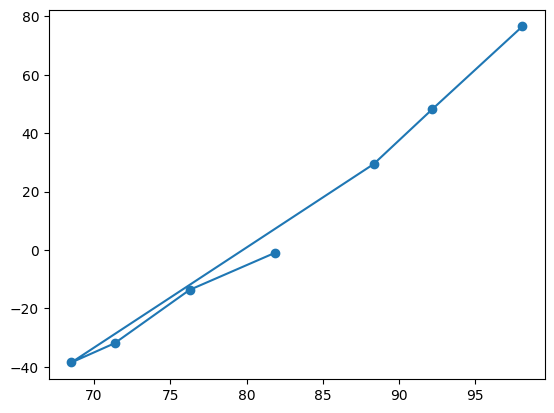

In [22]:
# plt.plot(reduced_ve_in_timestamps, F_red)
# plt.scatter(reduced_ve_in_timestamps, F_red)
# plt.show()

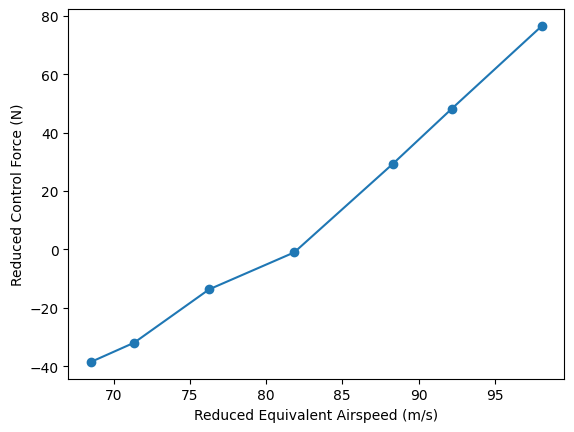

In [24]:
reduced_ve_in_timestamps = np.array(reduced_ve_in_timestamps)
F_red = np.array(F_red)

# Sort the data by the independent variable (x data)
sorted_indices = np.argsort(reduced_ve_in_timestamps)
sorted_x = reduced_ve_in_timestamps[sorted_indices]
sorted_y = F_red[sorted_indices]

# Plot the sorted data
plt.plot(sorted_x, sorted_y, marker='o')
plt.xlabel('Reduced Equivalent Airspeed (m/s)')
plt.ylabel('Reduced Control Force (N)')
plt.show()